# **Import Required Libraries**

In [1]:
import pandas as pd
import numpy as np
import re
from urllib.parse import urlparse
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from collections import Counter
import warnings
from imblearn.combine import SMOTETomek
from collections import Counter
warnings.filterwarnings("ignore")

# *Load and Clean Datasets*

In [2]:
# Load datasets
phish_df = pd.read_csv('/kaggle/input/dataset2/malicious_phish.csv')  # contains 'url', 'type'
spam_df = pd.read_csv('/kaggle/input/spamdataset/Spam.csv')              # pre-extracted features

# Clean phish_df
phish_df.rename(columns={'type': 'label'}, inplace=True)
phish_df['label'] = phish_df['label'].str.lower()

valid_labels = {'benign', 'phishing', 'defacement', 'malware'}
phish_df = phish_df[phish_df['label'].isin(valid_labels)].reset_index(drop=True)

# *Define Entropy and Feature Descriptions*

In [3]:
# Descriptions for each feature
feature_descriptions = {
    'Querylength': 'Length of the query string',
    'domain_token_count': 'Number of tokens in the domain',
    'path_token_count': 'Number of tokens in the path',
    'avgdomaintokenlen': 'Average length of domain tokens',
    'longdomaintokenlen': 'Length of the longest domain token',
    'avgpathtokenlen': 'Average length of path tokens',
    'tld': 'Top-level domain',
    'charcompvowels': 'Ratio of vowels to total characters',
    'charcompace': 'Ratio of consonants to total characters',
    'ldl_url': 'Longest digit sequence in URL',
    'ldl_domain': 'Longest digit sequence in domain',
    'ldl_path': 'Longest digit sequence in path',
    'ldl_filename': 'Longest digit sequence in filename',
    'ldl_getArg': 'Longest digit sequence in query arguments',
    'NumberofDotsinURL': 'Number of dots present in the URL',
    'CharacterContinuityRate': 'Ratio of repeated characters in the URL',
    'LongestVariableValue': 'Length of the longest query variable value',
    'URL_DigitCount': 'Total digit count in the URL',
    'host_DigitCount': 'Total digit count in the host',
    'Directory_DigitCount': 'Total digit count in directory names',
    'File_name_DigitCount': 'Total digit count in filename',
    'Extension_DigitCount': 'Total digit count in file extension',
    'Query_DigitCount': 'Total digit count in query string',
    'URL_Letter_Count': 'Total letter count in the URL',
    'host_letter_count': 'Total letter count in the host',
    'Directory_LetterCount': 'Total letter count in directory names',
    'Filename_LetterCount': 'Total letter count in filename',
    'Extension_LetterCount': 'Total letter count in file extension',
    'Query_LetterCount': 'Total letter count in query string',
    'LongestPathTokenLength': 'Length of the longest token in path',
    'Domain_LongestWordLength': 'Length of the longest word in domain',
    'Path_LongestWordLength': 'Length of the longest word in path',
    'sub-Directory_LongestWordLength': 'Length of the longest word in subdirectories',
    'Arguments_LongestWordLength': 'Length of the longest query argument',
    'spcharUrl': 'Total count of special characters in URL',
    'delimeter_Domain': 'Number of delimiters in the domain',
    'delimeter_path': 'Number of delimiters in the path',
    'delimeter_Count': 'Total number of delimiters in URL',
    'pathurlRatio': 'Ratio of path length to URL length',
    'ArgUrlRatio': 'Ratio of argument length to URL length',
    'argDomanRatio': 'Ratio of argument length to domain length',
    'domainUrlRatio': 'Ratio of domain length to URL length',
    'pathDomainRatio': 'Ratio of path length to domain length',
    'argPathRatio': 'Ratio of argument length to path length',
    'Entropy_URL': 'Shannon entropy of the URL',
    'Entropy_Domain': 'Shannon entropy of the domain',
    'Entropy_DirectoryName': 'Shannon entropy of directory names',
    'Entropy_Filename': 'Shannon entropy of filename',
    'Entropy_Extension': 'Shannon entropy of file extension',
    'Entropy_Afterpath': 'Shannon entropy of query string',
    'SymbolCount_URL': 'Total symbol count in URL',
    'SymbolCount_Domain': 'Total symbol count in domain',
    'SymbolCount_Directoryname': 'Total symbol count in directory names',
    'SymbolCount_FileName': 'Total symbol count in filename',
    'SymbolCount_Extension': 'Total symbol count in file extension',
    'SymbolCount_Afterpath': 'Total symbol count in query string'
}

# *Feature Extraction with Chunks*

In [4]:
def shannon_entropy(data):
    """Calculate Shannon entropy of a string"""
    if not data:
        return 0
    probs = [data.count(c) / len(data) for c in set(data)]
    return -sum(p * np.log2(p) for p in probs)

def extract_features_with_chunks(url):
    parsed = urlparse(url)
    netloc, path, query = parsed.netloc, parsed.path, parsed.query
    filename = path.split('/')[-1]
    file_ext = filename.split('.')[-1] if '.' in filename else ''
    
    # Extract domain
    domain_match = re.search(r'([a-zA-Z0-9-]+\.[a-zA-Z]{2,})$', netloc)
    domain = domain_match.group(1) if domain_match else netloc
    
    # Tokenization
    domain_tokens = domain.split('.')
    path_tokens = path.split('/')
    query_tokens = query.split('&')

    # Feature Extraction
    feature_data = {
        'Querylength': len(query),
        'domain_token_count': len(domain_tokens),
        'path_token_count': len([t for t in path_tokens if t]),
        'avgdomaintokenlen': np.mean([len(t) for t in domain_tokens]) if domain_tokens else 0,
        'longdomaintokenlen': max([len(t) for t in domain_tokens]) if domain_tokens else 0,
        'avgpathtokenlen': np.mean([len(t) for t in path_tokens if t]) if path_tokens else 0,
        'tld': str(domain.split('.')[-1]) if '.' in domain else '',

        
        'charcompvowels': sum(1 for c in url.lower() if c in "aeiou"),
        'charcompace': sum(1 for c in url.lower() if c in "ace"),
        'ldl_url': len(url),
        'ldl_domain': len(domain),
        'ldl_path': len(path),
        'ldl_filename': len(filename),
        'ldl_getArg': len(query),
        
        'NumberofDotsinURL': url.count('.'),
        'CharacterContinuityRate': len(re.findall(r'(.)\1{2,}', url)) / len(url) if len(url) else 0,
        'LongestVariableValue': max([len(t.split('=')[1]) for t in query_tokens if '=' in t], default=0) if query_tokens else 0,

        'URL_DigitCount': len(re.findall(r'\d', url)),
        'host_DigitCount': len(re.findall(r'\d', netloc)),
        'Directory_DigitCount': len(re.findall(r'\d', path)),
        'File_name_DigitCount': len(re.findall(r'\d', filename)),
        'Extension_DigitCount': len(re.findall(r'\d', file_ext)),
        'Query_DigitCount': len(re.findall(r'\d', query)),
        
        'URL_Letter_Count': len(re.findall(r'[a-zA-Z]', url)),
        'host_letter_count': len(re.findall(r'[a-zA-Z]', netloc)),
        'Directory_LetterCount': len(re.findall(r'[a-zA-Z]', path)),
        'Filename_LetterCount': len(re.findall(r'[a-zA-Z]', filename)),
        'Extension_LetterCount': len(re.findall(r'[a-zA-Z]', file_ext)),
        'Query_LetterCount': len(re.findall(r'[a-zA-Z]', query)),
        
        'LongestPathTokenLength': max([len(t) for t in path_tokens if t], default=0),
        'Domain_LongestWordLength': max([len(t) for t in domain_tokens], default=0),
        'Path_LongestWordLength': max([len(t) for t in path_tokens if t], default=0),
        'sub-Directory_LongestWordLength': max([len(t) for t in path_tokens], default=0),
        'Arguments_LongestWordLength': max([len(t) for t in query_tokens if '=' in t], default=0),
        
                
        'spcharUrl': len(re.findall(r'[^\w]', url)),
        'delimeter_Domain': domain.count('.'),
        'delimeter_path': path.count('/'),
        'delimeter_Count': url.count('/'),
        
        'pathurlRatio': len(path) / len(url) if len(url) else 0,
        'ArgUrlRatio': len(query) / len(url) if len(url) else 0,
        'argDomanRatio': len(query) / len(domain) if len(domain) else 0,
        'domainUrlRatio': len(domain) / len(url) if len(url) else 0,
        'pathDomainRatio': len(path) / len(domain) if len(domain) else 0,
        'argPathRatio': len(query) / len(path) if len(path) else 0,
        
        'Entropy_URL': shannon_entropy(url),
        'Entropy_Domain': shannon_entropy(domain),
        'Entropy_DirectoryName': shannon_entropy(path),
        'Entropy_Filename': shannon_entropy(filename),
        'Entropy_Extension': shannon_entropy(file_ext),
        'Entropy_Afterpath': shannon_entropy(query),
        
        'SymbolCount_URL': len(re.findall(r'[^\w]', url)),
        'SymbolCount_Domain': len(re.findall(r'[^\w]', domain)),
        'SymbolCount_Directoryname': len(re.findall(r'[^\w]', path)),
        'SymbolCount_FileName': len(re.findall(r'[^\w]', filename)),
        'SymbolCount_Extension': len(re.findall(r'[^\w]', file_ext)),
        'SymbolCount_Afterpath': len(re.findall(r'[^\w]', query))
    }
    return feature_data

def extract_features_for_df(url):
    chunks = extract_features_with_chunks(url)
    return {key: val_chunk[0] if isinstance(val_chunk, (list, tuple)) else val_chunk for key, val_chunk in chunks.items()}



# *Extract Features and Merge Data*

In [5]:
# Extract features from phishing dataset
features_list = phish_df['url'].apply(extract_features_for_df)
features_df = pd.DataFrame(features_list.tolist())
features_df['label'] = phish_df['label'].values

# Label spam dataset
spam_df['label'] = 'spam'

# Identify common columns
phish_cols, spam_cols = set(features_df.columns), set(spam_df.columns)

# Find columns in spam that are not in phishing
extra_spam_cols = spam_cols - phish_cols

# Remove those columns from spam dataset
spam_df.drop(columns=extra_spam_cols, inplace=True)

print(phish_cols - spam_cols)
# Ensure both datasets have the same columns before merging
for col in phish_cols - spam_cols:
    print('j')
    spam_df[col] = 0  

# Sort columns for consistency
features_df = features_df.sort_index(axis=1)
spam_df = spam_df.sort_index(axis=1)

# Merge datasets
final_df = pd.concat([features_df, spam_df], ignore_index=True)
final_df['label'] = final_df['label'].astype(str)


final_df.to_csv('final_merged_features.csv', index=False)
print("Final dataset shape:", final_df.shape)
print(final_df['label'].value_counts())
print("Saved to final_merged_features.csv")


set()
Final dataset shape: (665670, 57)
label
benign        428103
defacement     96457
phishing       94111
malware        32520
spam           14479
Name: count, dtype: int64
Saved to final_merged_features.csv


# *Display Feature Chunks for a URL*

In [6]:
def display_url_features_with_chunks(index):
    sample_url = phish_df.loc[index, 'url']
    sample_label = phish_df.loc[index, 'label']
    sample_features = extract_features_with_chunks(sample_url)

    print(f"\nAnalyzing URL:\n{sample_url}\n")
    print(f"{'Feature':<30}{'Value':<15}{'Explanation'}")
    print("-" * 90)

    for feature, value in sample_features.items():
        explanation = feature_descriptions.get(feature, 'No description')

        # Convert value to readable format
        if isinstance(value, (list, tuple)):  # If it's a list/tuple, show first element
            value_str = ', '.join(map(str, value[:3])) + ('...' if len(value) > 3 else '')
        elif isinstance(value, float):
            value_str = f"{value:.3f}"  # Format float values
        else:
            value_str = str(value)

        print(f"{feature:<30}{value_str:<15}{explanation}")
    
    print(f"\nLabel: {sample_label}")

# Call function for testing
display_url_features_with_chunks(3)



Analyzing URL:
http://www.garage-pirenne.be/index.php?option=com_content&view=article&id=70&vsig70_0=15

Feature                       Value          Explanation
------------------------------------------------------------------------------------------
Querylength                   49             Length of the query string
domain_token_count            2              Number of tokens in the domain
path_token_count              1              Number of tokens in the path
avgdomaintokenlen             8.000          Average length of domain tokens
longdomaintokenlen            14             Length of the longest domain token
avgpathtokenlen               9.000          Average length of path tokens
tld                           be             Top-level domain
charcompvowels                22             Ratio of vowels to total characters
charcompace                   14             Ratio of consonants to total characters
ldl_url                       88             Longest digit seque

**Check Final Columns**

In [7]:
print(final_df.columns)
len(final_df.columns)

Index(['ArgUrlRatio', 'Arguments_LongestWordLength', 'CharacterContinuityRate',
       'Directory_DigitCount', 'Directory_LetterCount',
       'Domain_LongestWordLength', 'Entropy_Afterpath',
       'Entropy_DirectoryName', 'Entropy_Domain', 'Entropy_Extension',
       'Entropy_Filename', 'Entropy_URL', 'Extension_DigitCount',
       'Extension_LetterCount', 'File_name_DigitCount', 'Filename_LetterCount',
       'LongestPathTokenLength', 'LongestVariableValue', 'NumberofDotsinURL',
       'Path_LongestWordLength', 'Query_DigitCount', 'Query_LetterCount',
       'Querylength', 'SymbolCount_Afterpath', 'SymbolCount_Directoryname',
       'SymbolCount_Domain', 'SymbolCount_Extension', 'SymbolCount_FileName',
       'SymbolCount_URL', 'URL_DigitCount', 'URL_Letter_Count',
       'argDomanRatio', 'argPathRatio', 'avgdomaintokenlen', 'avgpathtokenlen',
       'charcompace', 'charcompvowels', 'delimeter_Count', 'delimeter_Domain',
       'delimeter_path', 'domainUrlRatio', 'domain_token_count

57

# *Handle Missing Values*

**Find Skewness of Data**

In [8]:


# Apply skew function only on numeric columns
skewness = final_df.select_dtypes(include=['number']).apply(lambda x: skew(x.dropna()))



**Find types of Skewness**

In [9]:
# Sort the features by skewness value
sorted_skewness = skewness.sort_values()

# Identify different categories
highly_skewed = sorted_skewness[abs(sorted_skewness) > 2]
moderately_skewed = sorted_skewness[(abs(sorted_skewness) > 1) & (abs(sorted_skewness) <= 2)]
approximately_normal = sorted_skewness[abs(sorted_skewness) <= 1]

# Display results
print("\nHighly Skewed Features:\n", highly_skewed)
print("\nModerately Skewed Features:\n", moderately_skewed)
print("\nApproximately Normal Features:\n", approximately_normal)


Highly Skewed Features:
 Entropy_URL                        -2.969590
Entropy_DirectoryName              -2.581766
longdomaintokenlen                  2.087127
host_letter_count                   2.088855
Domain_LongestWordLength            2.100512
delimeter_Domain                    2.198274
domain_token_count                  2.206668
delimeter_path                      2.237571
SymbolCount_Domain                  2.346973
domainUrlRatio                      2.411619
charcompvowels                      2.865632
path_token_count                    2.887414
Filename_LetterCount                2.965974
charcompace                         3.156373
ldl_path                            3.283191
ldl_url                             3.782387
Directory_LetterCount               3.956305
NumberofDotsinURL                   4.044160
sub-Directory_LongestWordLength     4.218579
Path_LongestWordLength              4.222509
SymbolCount_URL                     4.290263
spcharUrl                    

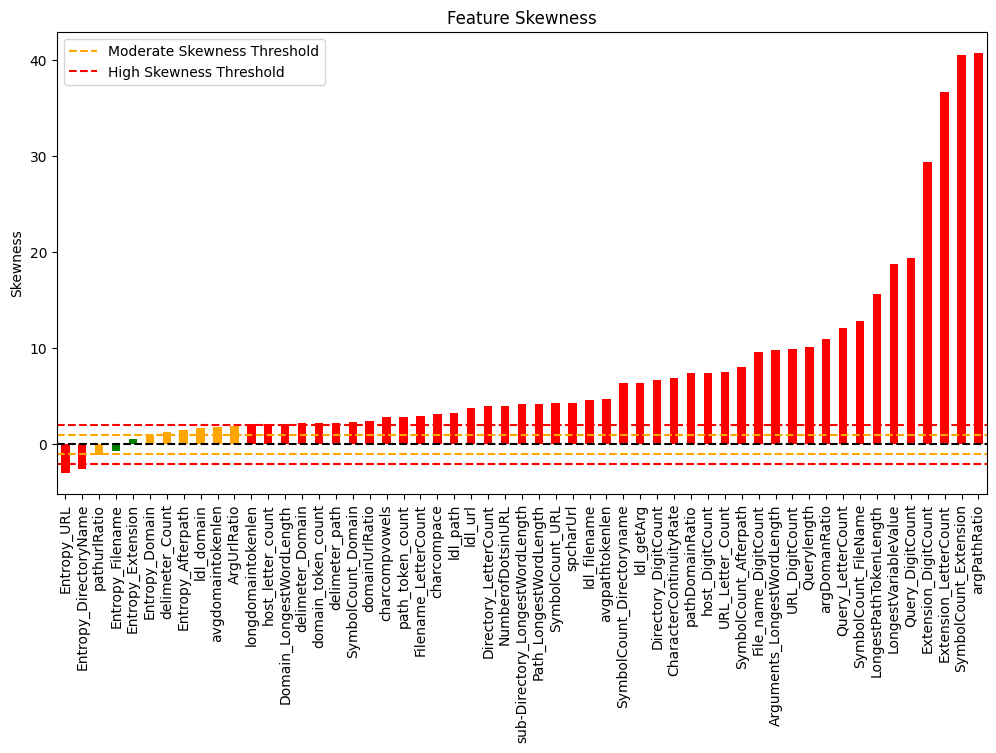

In [10]:
plt.figure(figsize=(12, 6))
sorted_skewness.plot(kind='bar', color=['red' if abs(i) > 2 else 'orange' if abs(i) > 1 else 'green' for i in sorted_skewness])
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=1, color='orange', linestyle='dashed', label='Moderate Skewness Threshold')
plt.axhline(y=-1, color='orange', linestyle='dashed')
plt.axhline(y=2, color='red', linestyle='dashed', label='High Skewness Threshold')
plt.axhline(y=-2, color='red', linestyle='dashed')
plt.legend()
plt.title("Feature Skewness")
plt.ylabel("Skewness")
plt.show()

**Check for missing values**

In [11]:
print("Missing values per column:")
print(final_df.isnull().sum())


Missing values per column:
ArgUrlRatio                           0
Arguments_LongestWordLength           0
CharacterContinuityRate               0
Directory_DigitCount                  0
Directory_LetterCount                 0
Domain_LongestWordLength              0
Entropy_Afterpath                     3
Entropy_DirectoryName              1879
Entropy_Domain                        0
Entropy_Extension                     3
Entropy_Filename                    166
Entropy_URL                           0
Extension_DigitCount                  0
Extension_LetterCount                 0
File_name_DigitCount                  0
Filename_LetterCount                  0
LongestPathTokenLength                0
LongestVariableValue                  0
NumberofDotsinURL                     0
Path_LongestWordLength                0
Query_DigitCount                      0
Query_LetterCount                     0
Querylength                           0
SymbolCount_Afterpath                 0
SymbolCount_D

**filling missing rows**

In [12]:
# Fill NaN values for Highly Skewed Features using median
final_df[highly_skewed.index] = final_df[highly_skewed.index].fillna(final_df[highly_skewed.index].median())

# Fill NaN values for Moderately Skewed Features dynamically
for feature in moderately_skewed.index:
    skew_value = skew(final_df[feature].dropna())  # Compute skewness ignoring NaN values
    
    if 1 <= abs(skew_value) < 1.5:
        final_df[feature] = final_df[feature].fillna(final_df[feature].mean())
    elif 1.5 <= abs(skew_value) <= 2:
        final_df[feature] = final_df[feature].fillna(final_df[feature].median())

# Fill NaN values for Approximately Normal Features using mean
final_df[approximately_normal.index] = final_df[approximately_normal.index].fillna(final_df[approximately_normal.index].mean())

# Check if all NaN values are handled
print("Missing values after imputation:", final_df.isnull().sum().sum())  # Should return 0 if all NaN values are filled


Missing values after imputation: 0


# *Handling Duplicates*

**Check for Duplicates**

In [13]:
# Check how many duplicate rows exist
num_duplicates = final_df.duplicated().sum()
print("Total duplicate rows:", num_duplicates)

# Display random sample of duplicate rows (if any exist)
if num_duplicates > 0:
    duplicates = final_df[final_df.duplicated()]
    print("Sample duplicate rows:")
    print(duplicates.sample(min(5, num_duplicates)))  


Total duplicate rows: 86623
Sample duplicate rows:
        ArgUrlRatio  Arguments_LongestWordLength  CharacterContinuityRate  \
660859     0.598039                            6                 0.428571   
175288     0.673913                           21                 0.000000   
373778     0.000000                            0                 0.036364   
486420     0.000000                            0                 0.016393   
297093     0.208333                           10                 0.000000   

        Directory_DigitCount  Directory_LetterCount  Domain_LongestWordLength  \
660859                     0                      3                         8   
175288                     0                      8                         9   
373778                    12                     36                         0   
486420                    10                     43                         0   
297093                     0                     17                         6   


**Remove Duplicates**

In [14]:

# Remove duplicates
print("Before removing duplicates:", final_df.shape)
final_df.drop_duplicates(inplace=True)
print("After removing duplicates:", final_df.shape)


Before removing duplicates: (665670, 57)
After removing duplicates: (579047, 57)


In [15]:
final_df

,ArgUrlRatio,Arguments_LongestWordLength,CharacterContinuityRate,Directory_DigitCount,Directory_LetterCount,Domain_LongestWordLength,Entropy_Afterpath,Entropy_DirectoryName,Entropy_Domain,Entropy_Extension,...,ldl_getArg,ldl_path,ldl_url,longdomaintokenlen,pathDomainRatio,path_token_count,pathurlRatio,spcharUrl,sub-Directory_LongestWordLength,tld
0,0.000000,0,0.000000,0,13,0,0.000000,3.375000,0.000000,1.000000,...,0,16,16,0,0.000000,1,1.000000,3,16,
1,0.000000,0,0.000000,1,29,0,0.000000,4.079143,0.000000,2.000000,...,0,35,35,0,0.000000,3,1.000000,4,17,
2,0.000000,0,0.000000,1,25,0,0.000000,3.708093,0.000000,1.584963,...,0,31,31,0,0.000000,4,1.000000,5,14,
3,0.556818,18,0.011364,0,8,14,4.280341,3.121928,3.146286,0.918296,...,49,10,88,14,0.588235,1,0.113636,16,9,be
4,0.825532,161,0.000000,0,8,19,5.360074,3.121928,3.501398,0.918296,...,194,10,235,19,0.434783,1,0.042553,13,9,net
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
665662,0.192982,0,0.500000,0,15,4,0.947443,0.783307,0.879588,0.931745,...,1,1,1,4,4.000000,7,0.701754,4,8,3
665664,0.047619,-1,0.687500,0,4,10,-1.000000,0.898227,0.843750,1.000000,...,0,1,1,10,1.187500,5,0.452381,3,4,3
665665,0.582192,23,0.500000,4,46,12,0.796205,0.777498,0.791265,0.656684,...,2,3,3,12,4.346154,14,0.773973,6,11,4
665667,0.739837,0,0.772727,6,71,16,0.705245,0.684777,0.801139,0.717187,...,18,20,20,16,9.863636,27,0.882114,12,12,3


# Encode Categorical Variables

In [16]:
# Encode labels only if 'label' column exists
if 'label' in final_df.columns:
    if final_df['label'].dtype == 'object':
        le = LabelEncoder()
        final_df['label_encoded'] = le.fit_transform(final_df['label'])
    else:
        final_df['label_encoded'] = final_df['label']  # Keep as is if already numeric

if 'tld' in final_df.columns:
    # Convert all values in 'tld' column to strings
    final_df['tld'] = final_df['tld'].astype(str)
    
    # Apply Label Encoding
    le = LabelEncoder()
    final_df['tld_encoded'] = le.fit_transform(final_df['tld'])
    
    # Drop original 'tld' column
    final_df.drop(columns=['tld'], inplace=True)

# Ensure 'tld' exists before encoding
if 'tld' in final_df.columns:
    le = LabelEncoder()
    final_df['tld_encoded'] = le.fit_transform(final_df['tld'])
    final_df.drop(columns=['tld'], inplace=True)  # Remove original 'tld' column

final_df.drop(columns=['label'], inplace=True)

**Check if any categorical column left**

In [17]:
non_numeric_cols = final_df.select_dtypes(exclude=['number']).columns
print("Non-numeric columns:", non_numeric_cols)


Non-numeric columns: Index([], dtype='object')


# *Correlation*

In [18]:
correlation_with_target = final_df.corr()['label_encoded'].sort_values(ascending=False)
print(correlation_with_target )

label_encoded                      1.000000
CharacterContinuityRate            0.440494
domain_token_count                 0.407485
SymbolCount_Domain                 0.386669
domainUrlRatio                     0.369031
host_letter_count                  0.331873
avgdomaintokenlen                  0.315607
longdomaintokenlen                 0.307252
Domain_LongestWordLength           0.299834
tld_encoded                        0.299394
Entropy_Domain                     0.284506
delimeter_Domain                   0.270223
ldl_domain                         0.244286
host_DigitCount                    0.184679
Extension_DigitCount               0.169003
NumberofDotsinURL                  0.167762
SymbolCount_Extension              0.165440
pathDomainRatio                    0.163341
Extension_LetterCount              0.149043
argDomanRatio                      0.126936
Entropy_Extension                  0.080661
path_token_count                   0.070795
Query_LetterCount               

Selected Strong Features: ['label_encoded', 'CharacterContinuityRate', 'domain_token_count', 'SymbolCount_Domain', 'domainUrlRatio', 'host_letter_count', 'avgdomaintokenlen', 'longdomaintokenlen', 'ldl_path', 'Directory_LetterCount', 'Entropy_URL', 'Entropy_DirectoryName']


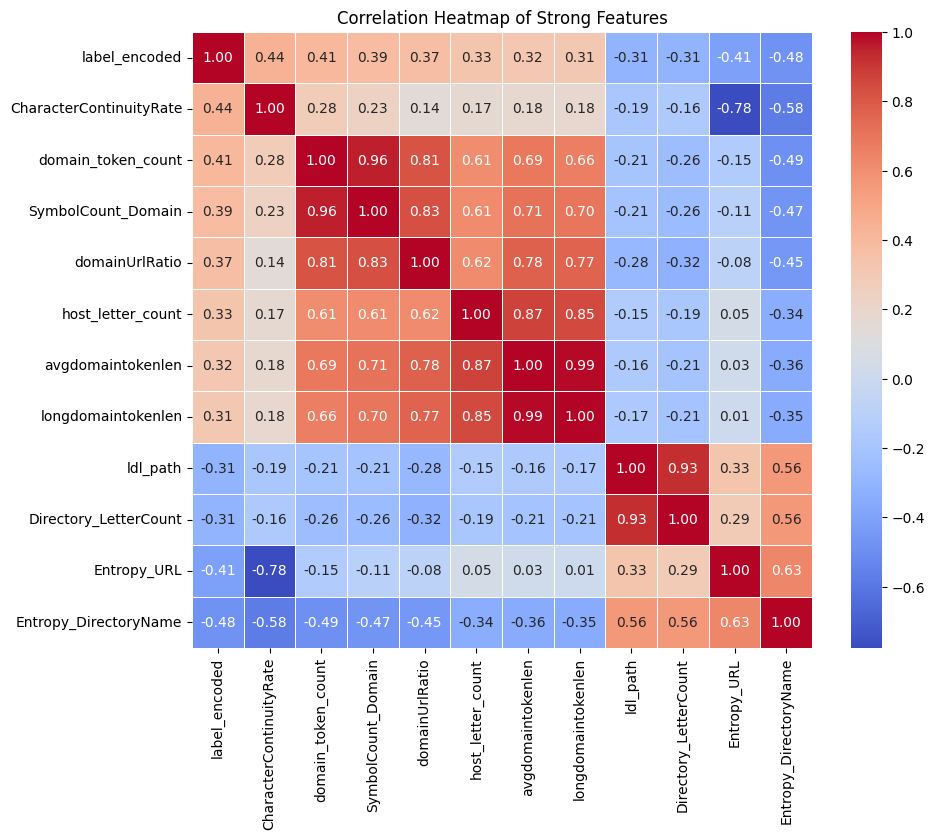

In [19]:
# Define a stricter correlation threshold
correlation_threshold = 0.3 


# Compute correlation with target
correlation_with_target = final_df.corr()['label_encoded'].sort_values(ascending=False)

# Keep only features within the specified correlation range
strong_features = correlation_with_target[
    (abs(correlation_with_target) >= correlation_threshold)
].index

# Filter dataset to retain only strong features
final_df_strong = final_df[strong_features]

# Drop 'label_encoded' from features if keeping it separately for model training
X = final_df_strong.drop(columns=['label_encoded'], errors='ignore')
y = final_df['label_encoded']

# Print the selected features
print("Selected Strong Features:", list(strong_features))


# Compute correlation matrix for strong features
plt.figure(figsize=(10, 8))
sns.heatmap(final_df_strong.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Strong Features")
plt.show()

In [20]:
# Save X (features) to CSV
X.to_csv("my_X_features.csv", index=False)

# Save y (labels) to CSV
y.to_csv("my_y_labels.csv", index=False)

print("X and y saved as CSV files successfully!")


X and y saved as CSV files successfully!


# *Check Classes Distribution*

Class Distribution Before Balancing:
label_encoded
0    386457
3     84438
1     76789
2     18579
4     12784
Name: count, dtype: int64


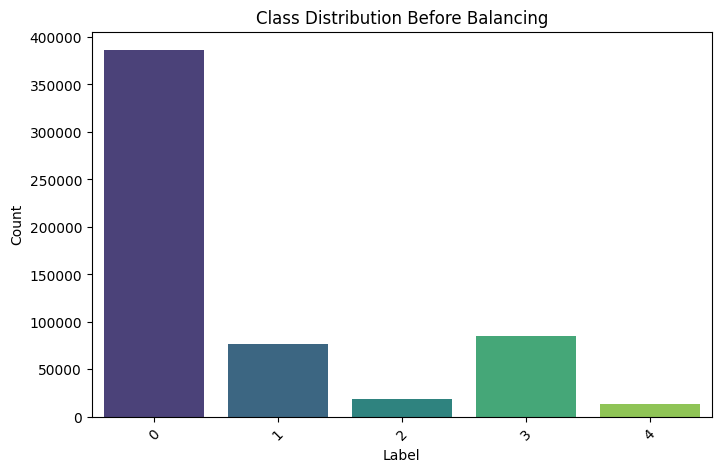

Imbalance Ratio (Max/Min Class Count): 30.23


In [21]:


# Check class distribution
class_counts = final_df_strong['label_encoded'].value_counts()
print("Class Distribution Before Balancing:")
print(class_counts)

# Plot class distribution
plt.figure(figsize=(8, 5))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("Class Distribution Before Balancing")
plt.xticks(rotation=45)
plt.show()

# Calculate class imbalance ratio
min_class = class_counts.min()
max_class = class_counts.max()
imbalance_ratio = max_class / min_class if min_class > 0 else float('inf')
print(f"Imbalance Ratio (Max/Min Class Count): {imbalance_ratio:.2f}")


# *Balancing the Dataset*

In [22]:

# Initialize SMOTETomek (SMOTE + Undersampling)
smote_tomek = SMOTETomek(random_state=42)

# Apply SMOTETomek to balance the dataset
X_resampled, y_resampled = smote_tomek.fit_resample(X, y)

# Print the new class distribution
print("Class Distribution After SMOTE + Undersampling:", Counter(y_resampled))

Class Distribution After SMOTE + Undersampling: Counter({4: 386457, 1: 385568, 2: 384725, 0: 377108, 3: 376467})


Class Distribution After SMOTE + Undersampling: Counter({4: 386457, 1: 385568, 2: 384725, 0: 377108, 3: 376467})
Imbalance Ratio (Max/Min Class Count): 1.03


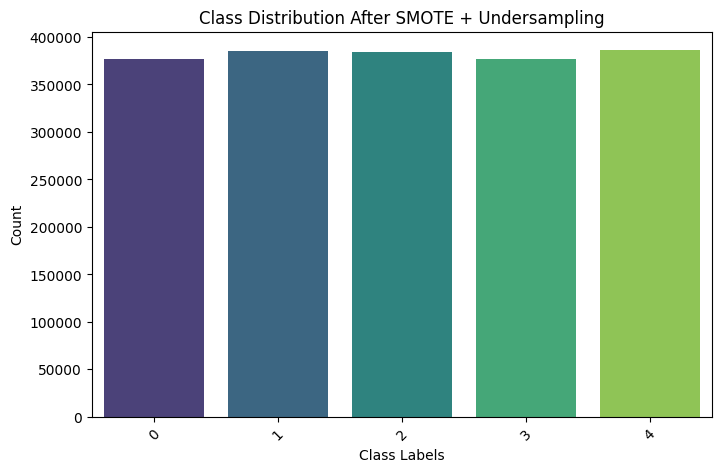

In [23]:
# Get class counts
class_counts = Counter(y_resampled)

# Compute imbalance ratio (max/min class count)
min_class = min(class_counts.values())  # Get the smallest class count
max_class = max(class_counts.values())  # Get the largest class count

imbalance_ratio = max_class / min_class if min_class > 0 else float('inf')
print("Class Distribution After SMOTE + Undersampling:", class_counts)
print(f"Imbalance Ratio (Max/Min Class Count): {imbalance_ratio:.2f}")


# Function to plot class distribution
def plot_class_distribution(y, title):
    class_counts = Counter(y)
    classes, counts = zip(*class_counts.items())

    plt.figure(figsize=(8, 5))
    sns.barplot(x=list(classes), y=list(counts), palette="viridis")
    plt.xlabel("Class Labels")
    plt.ylabel("Count")
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()


# Plot after resampling
plot_class_distribution(y_resampled, "Class Distribution After SMOTE + Undersampling")

🔹 Splitting Data into Training and Testing Sets...
🔹 Initializing Models...

 Training Random Forest (CPU)...
Random Forest Training Completed.

 Training XGBoost (GPU)...
XGBoost Training Completed (Using GPU).

🔹 Making Predictions...

🔹 **Random Forest Performance:**
              precision    recall  f1-score   support

           0       0.89      0.93      0.91     75310
           1       0.98      0.99      0.98     77044
           2       0.98      0.97      0.98     77097
           3       0.90      0.86      0.88     75478
           4       1.00      1.00      1.00     77136

    accuracy                           0.95    382065
   macro avg       0.95      0.95      0.95    382065
weighted avg       0.95      0.95      0.95    382065

Confusion Matrix:
[[69871    72   219  5148     0]
 [   89 76511   109   335     0]
 [  750   157 74557  1633     0]
 [ 7955  1679   834 65010     0]
 [    0     0     0     0 77136]]

🔹 **XGBoost Performance (GPU Enabled):**
              

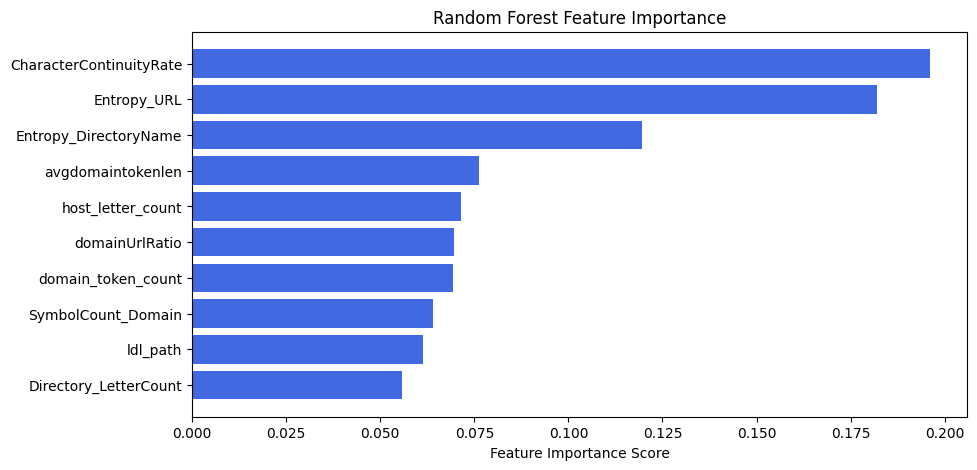


🔹 Plotting Feature Importance for XGBoost (GPU)...


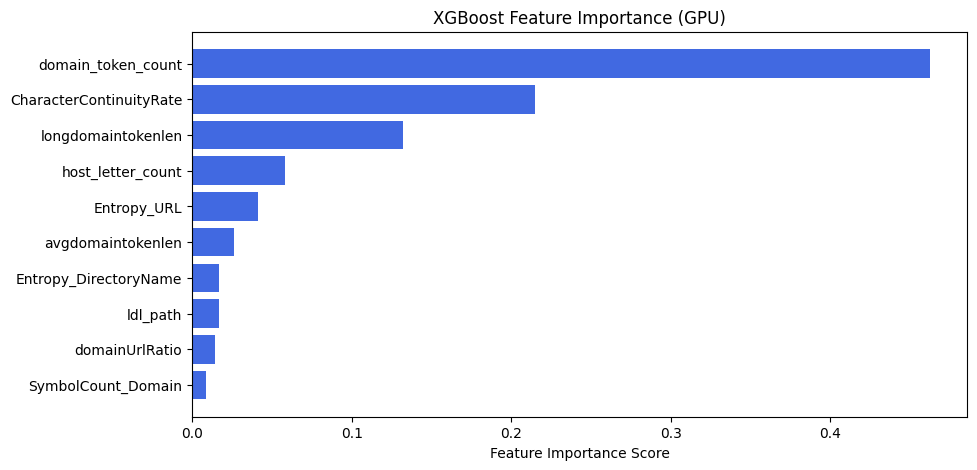


 Model Training & Evaluation Completed Successfully! 


In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Split data into train and test sets
print("🔹 Splitting Data into Training and Testing Sets...")
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Initialize Models
print("🔹 Initializing Models...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Use CUDA for XGBoost
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42, 
                          use_label_encoder=False, eval_metric="mlogloss", tree_method="gpu_hist")

# Train Models
print("\n Training Random Forest (CPU)...")
rf_model.fit(X_train, y_train)
print("Random Forest Training Completed.")

print("\n Training XGBoost (GPU)...")
xgb_model.fit(X_train, y_train)
print("XGBoost Training Completed (Using GPU).")

# Predict on Test Set
print("\n🔹 Making Predictions...")
y_pred_rf = rf_model.predict(X_test)
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate Performance
print("\n🔹 **Random Forest Performance:**")
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

print("\n🔹 **XGBoost Performance (GPU Enabled):**")
print(classification_report(y_test, y_pred_xgb))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))

# Feature Importance Plot
def plot_feature_importance(model, feature_names, title):
    importance = model.feature_importances_
    sorted_idx = np.argsort(importance)[-10:]  # Get top 10 features
    plt.figure(figsize=(10, 5))
    plt.barh(np.array(feature_names)[sorted_idx], importance[sorted_idx], color='royalblue')
    plt.xlabel("Feature Importance Score")
    plt.title(title)
    plt.show()

# Plot Feature Importance
print("\n🔹 Plotting Feature Importance for Random Forest...")
plot_feature_importance(rf_model, X.columns, "Random Forest Feature Importance")

print("\n🔹 Plotting Feature Importance for XGBoost (GPU)...")
plot_feature_importance(xgb_model, X.columns, "XGBoost Feature Importance (GPU)")

print("\n Model Training & Evaluation Completed Successfully! ")


# **Insights from the Dataset**

In [27]:
# Basic dataset information
print("Dataset Info:")
print(final_df.info())

# Check the first few rows
print("\nSample Data:")
print(final_df.head())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 579047 entries, 0 to 665669
Data columns (total 57 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   ArgUrlRatio                      579047 non-null  float64
 1   Arguments_LongestWordLength      579047 non-null  int64  
 2   CharacterContinuityRate          579047 non-null  float64
 3   Directory_DigitCount             579047 non-null  int64  
 4   Directory_LetterCount            579047 non-null  int64  
 5   Domain_LongestWordLength         579047 non-null  int64  
 6   Entropy_Afterpath                579047 non-null  float64
 7   Entropy_DirectoryName            579047 non-null  float64
 8   Entropy_Domain                   579047 non-null  float64
 9   Entropy_Extension                579047 non-null  float64
 10  Entropy_Filename                 579047 non-null  float64
 11  Entropy_URL                      579047 non-null  float6

# **4) EDA**

# **Data Distributions & Identifying Patterns**

In [28]:
# Summary statistics for numerical features
print("\nDescriptive Statistics:")
print(final_df.describe().T)

# Check class distribution
print("\nClass Distribution:")
print(final_df['label_encoded'].value_counts(normalize=True) * 100)



Descriptive Statistics:
                                    count         mean          std  min  \
ArgUrlRatio                      579047.0     0.100312     0.221701  0.0   
Arguments_LongestWordLength      579047.0     6.607308    24.407560 -1.0   
CharacterContinuityRate          579047.0     0.018936     0.099152  0.0   
Directory_DigitCount             579047.0     3.392645     8.212637 -1.0   
Directory_LetterCount            579047.0    33.292061    21.668109 -1.0   
Domain_LongestWordLength         579047.0     2.618451     5.041697  0.0   
Entropy_Afterpath                579047.0     0.756103     1.610168 -1.0   
Entropy_DirectoryName            579047.0     3.881283     0.716718 -1.0   
Entropy_Domain                   579047.0     0.840093     1.384684  0.0   
Entropy_Extension                579047.0     0.742932     0.871640 -1.0   
Entropy_Filename                 579047.0     2.462895     1.495506 -1.0   
Entropy_URL                      579047.0     4.156344     0.65

# **Distribution of Numerical Features**

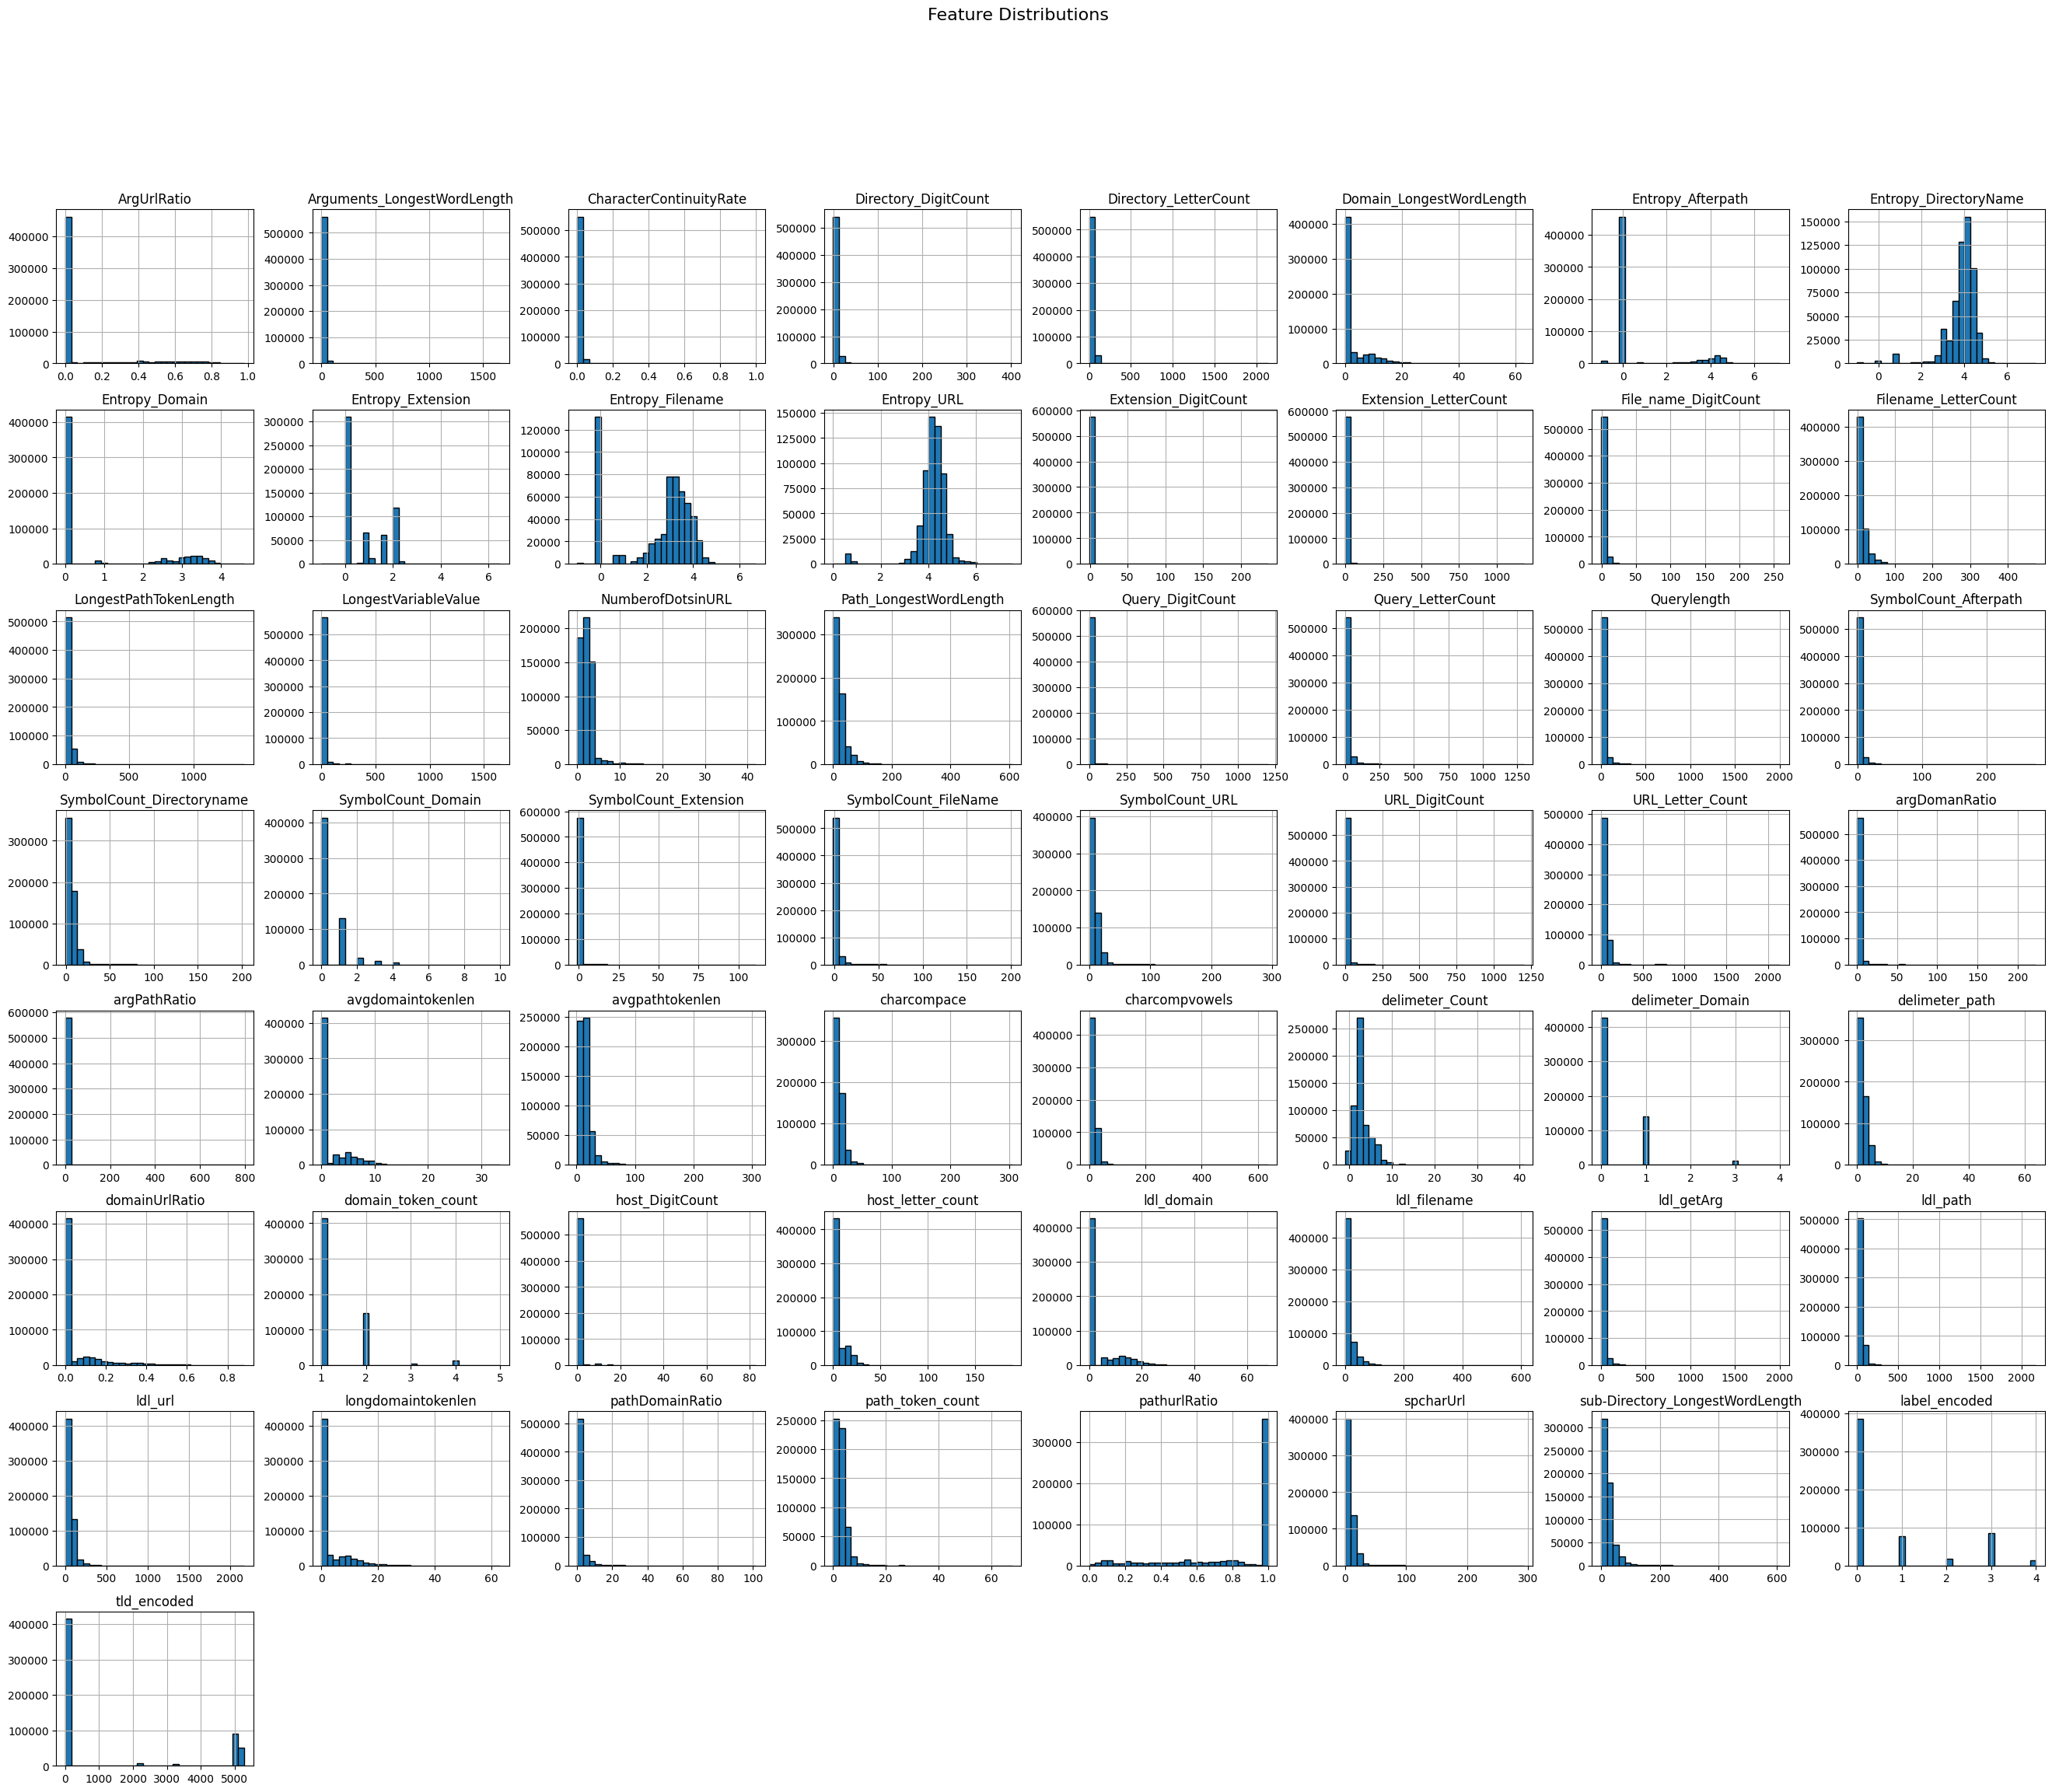

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot histograms for numerical columns
final_df.hist(figsize=(33, 26), bins=30, edgecolor='black')
plt.suptitle("Feature Distributions", fontsize=16)
plt.show()


# **Checking for Outliers Using Boxplots**

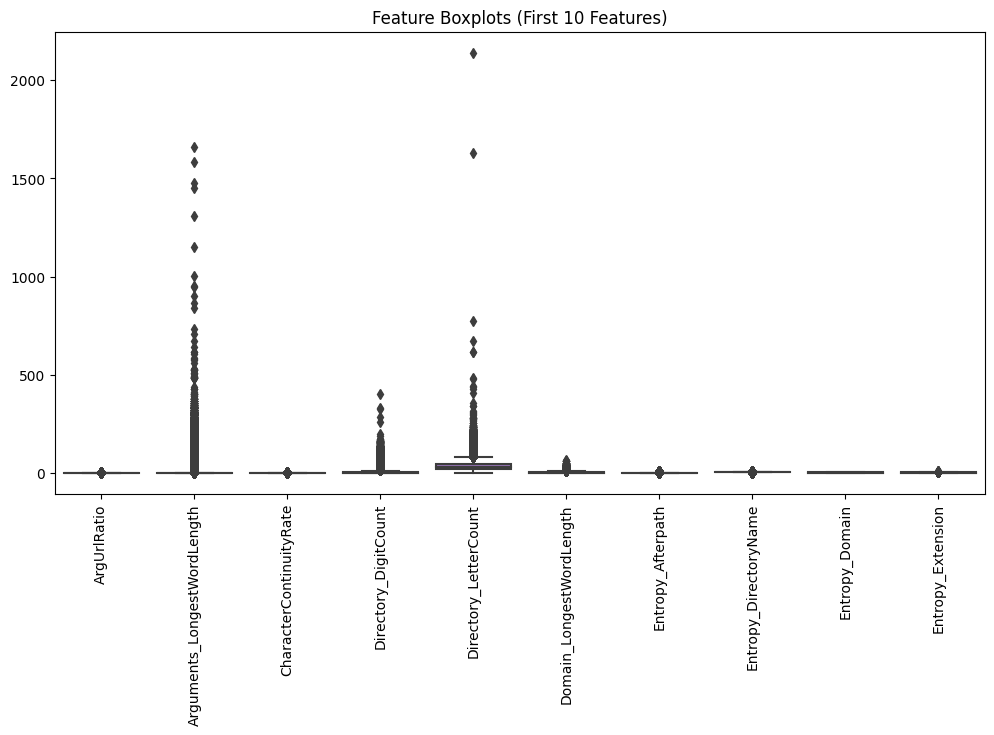

In [33]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=final_df.iloc[:, :10])  # First 10 numerical features
plt.xticks(rotation=90)
plt.title("Feature Boxplots (First 10 Features)")
plt.show()


# **Correlation Analysis**

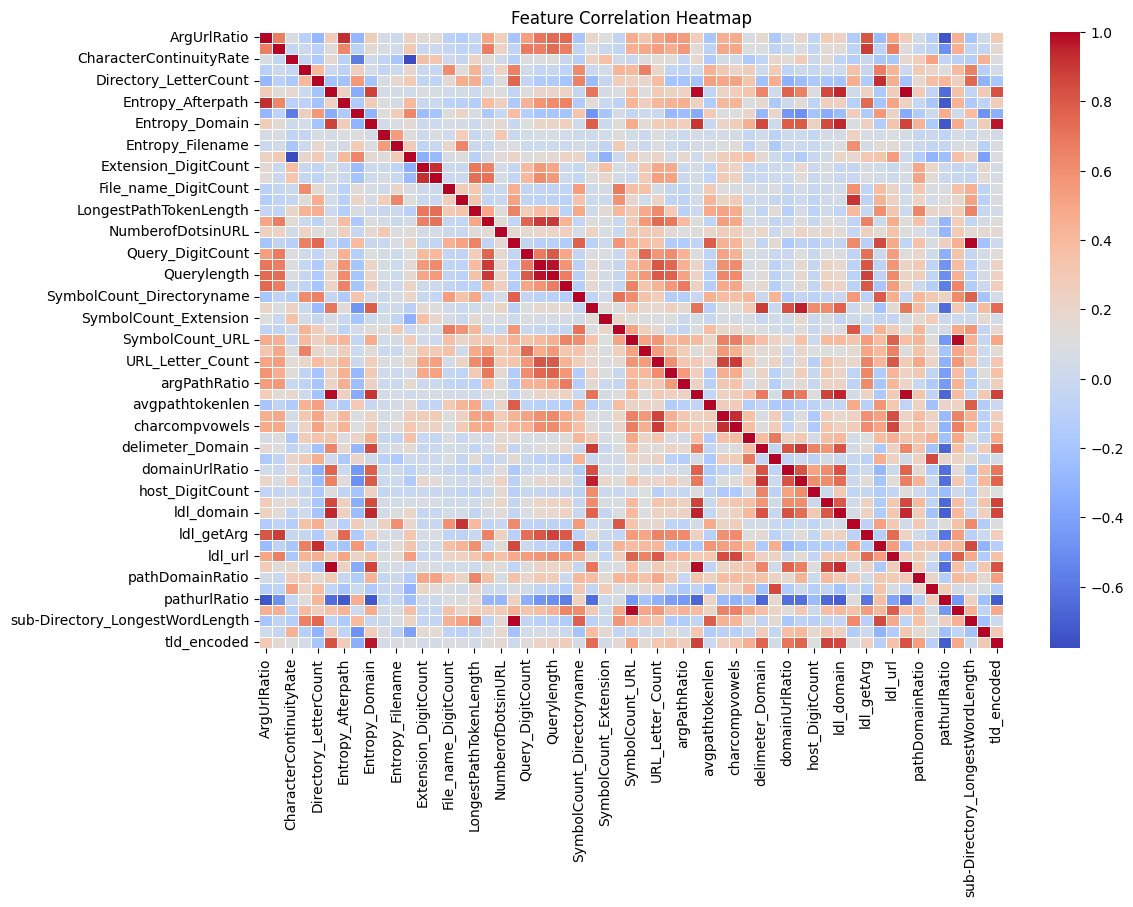


Top 10 features most correlated with the label:
Entropy_DirectoryName      0.480087
CharacterContinuityRate    0.440494
Entropy_URL                0.413635
domain_token_count         0.407485
SymbolCount_Domain         0.386669
domainUrlRatio             0.369031
host_letter_count          0.331873
avgdomaintokenlen          0.315607
longdomaintokenlen         0.307252
Directory_LetterCount      0.306998
Name: label_encoded, dtype: float64


In [36]:
# Compute correlation matrix
corr_matrix = final_df.corr()

# Plot heatmap of correlations
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

# Identify top correlated features with 'label'
correlation_target = corr_matrix["label_encoded"].abs().sort_values(ascending=False)
print("\nTop 10 features most correlated with the label:")
print(correlation_target[1:11])


# **Violin Plots for Better Distribution Insight**

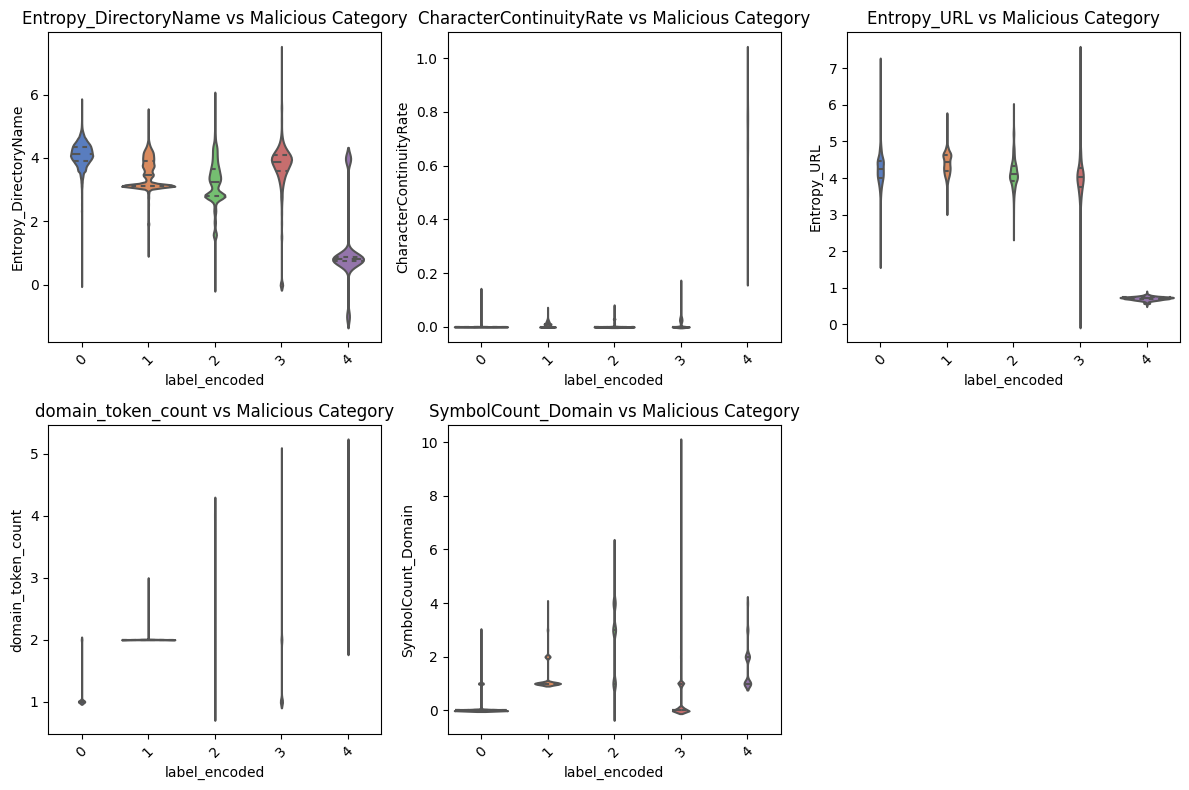

In [40]:
plt.figure(figsize=(12, 8))
for i, feature in enumerate(top_features, 1):
    plt.subplot(2, 3, i)
    sns.violinplot(x=final_df['label_encoded'], y=final_df[feature], inner="quartile", palette="muted")
    plt.title(f"{feature} vs Malicious Category")
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# **Bar Plots of Feature Means per Category**

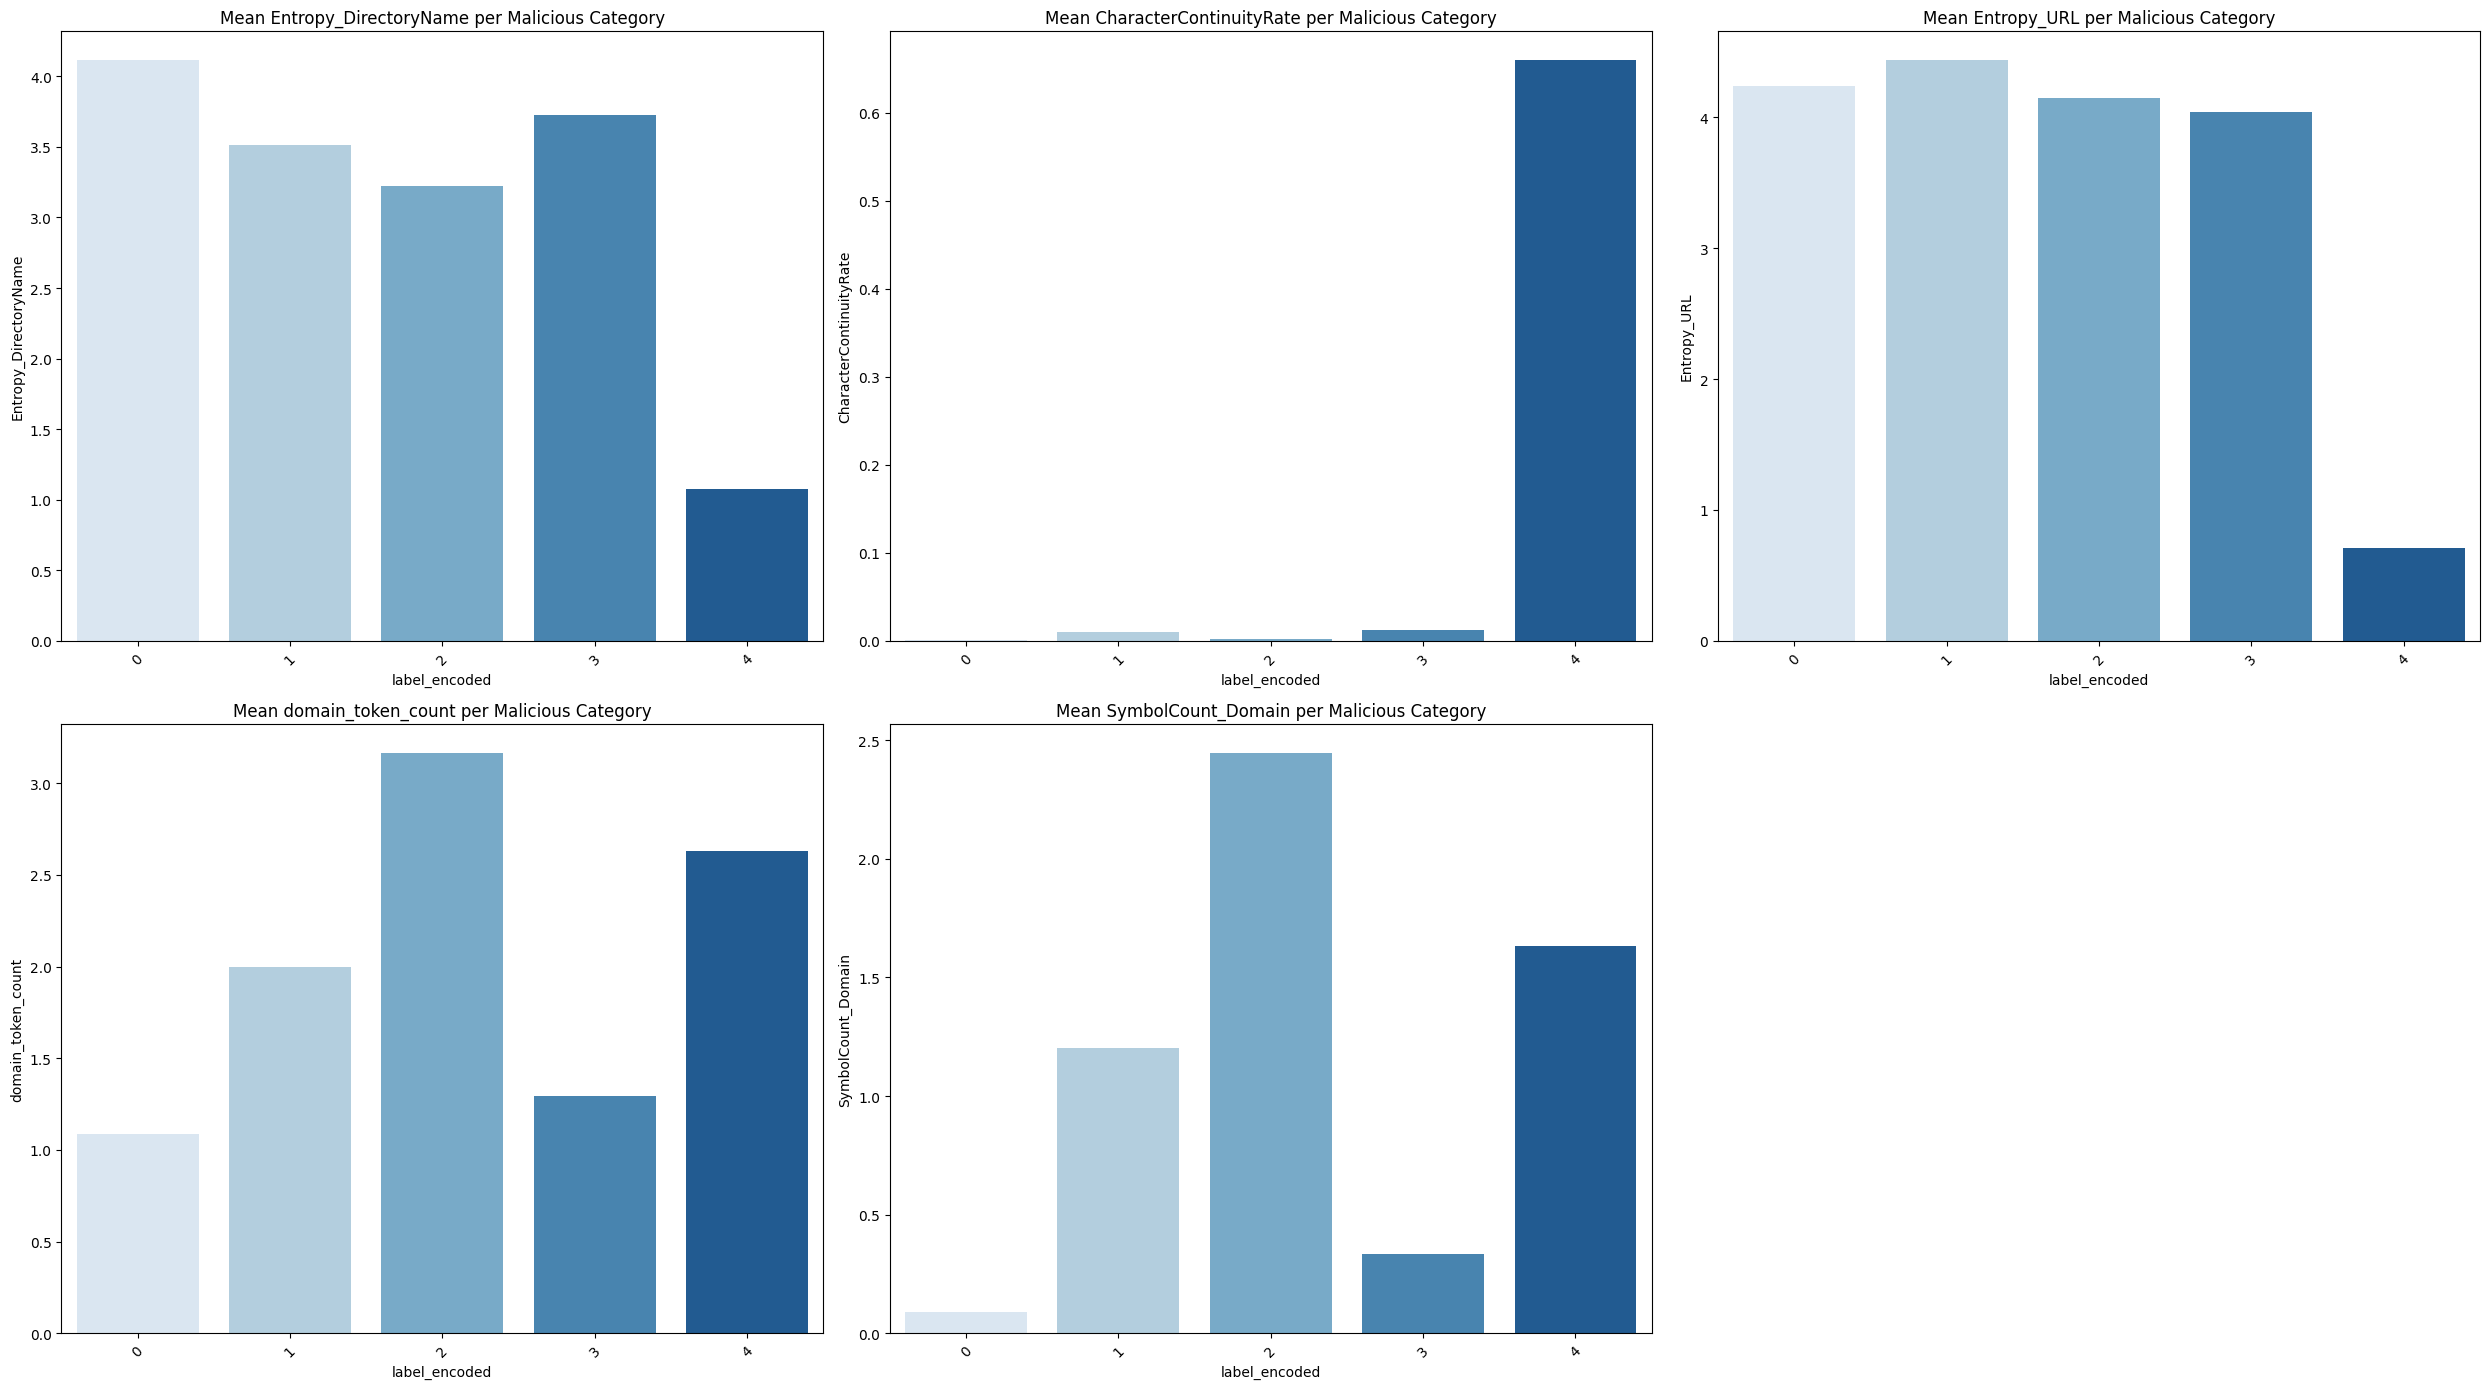

In [49]:
plt.figure(figsize=(25, 14))
for i, feature in enumerate(top_features, 1):
    plt.subplot(2, 3, i)
    sns.barplot(x=final_df['label_encoded'], y=final_df[feature], ci=None, palette="Blues")
    plt.title(f"Mean {feature} per Malicious Category")
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [ ]:
Heatmap Feature Relationship

# **Heatmap of Most Useful cols (Feature Relationship)**

In [51]:
top_10_features = [
    "Entropy_DirectoryName", "CharacterContinuityRate", "Entropy_URL",
    "domain_token_count", "SymbolCount_Domain", "domainUrlRatio",
    "host_letter_count", "avgdomaintokenlen", "longdomaintokenlen",
    "Directory_LetterCount"
]

# Display summary statistics
final_df[top_10_features].describe()


,Entropy_DirectoryName,CharacterContinuityRate,Entropy_URL,domain_token_count,SymbolCount_Domain,domainUrlRatio,host_letter_count,avgdomaintokenlen,longdomaintokenlen,Directory_LetterCount
count,579047.000000,579047.000000,579047.000000,579047.000000,579047.00000,579047.000000,579047.000000,579047.000000,579047.000000,579047.000000
mean,3.881283,0.018936,4.156344,1.339967,0.38186,0.057902,4.055470,1.652586,2.633399,33.292061
std,0.716718,0.099152,0.651691,0.618995,0.72217,0.119053,7.643329,3.000754,5.054525,21.668109
min,-1.000000,0.000000,-0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,-1.000000
25%,3.690117,0.000000,3.967720,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,19.000000
50%,4.018082,0.000000,4.219599,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,30.000000
75%,4.277567,0.000000,4.480193,2.000000,1.00000,0.070423,7.000000,2.500000,3.000000,43.000000
max,7.347967,1.000000,7.504113,5.000000,10.00000,0.882353,189.000000,33.500000,63.000000,2141.000000


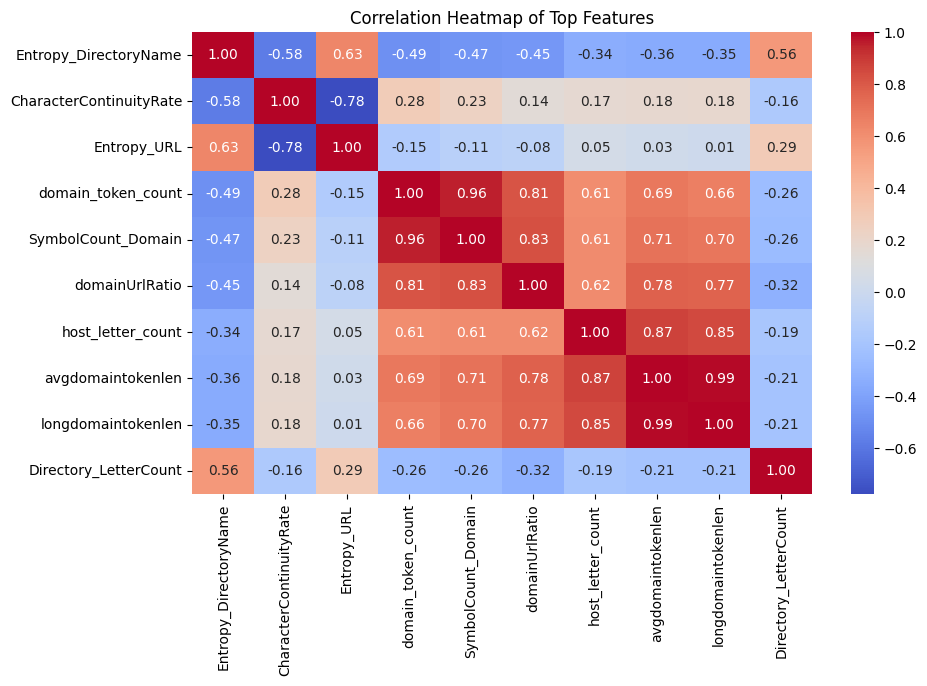

In [52]:
plt.figure(figsize=(10, 6))
sns.heatmap(final_df[top_10_features].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Top Features")
plt.show()

# **Summary**

Summary of Insights from EDA:
1️⃣ Malicious URLs have higher entropy (randomness) in directory names and 
the overall URL, making them harder to blacklist.
2️⃣ Malicious URLs tend to have more special symbols and domain tokens, as 
attackers try to confuse security systems.
3️⃣ Certain features, like CharacterContinuityRate and domainUrlRatio, show distinct patterns 
for malicious vs. benign URLs, making them valuable for classification.
4️⃣ Outliers exist in several features, which may require handling via transformation or removal.
5️⃣ Some features are highly correlated, so we may need feature selection to remove redundant ones.

# **5) GRAPHS AND PLOTS**

# **KDE Plot**

Visualizing how URL entropy varies for different types of URLs (malicious vs. benign).

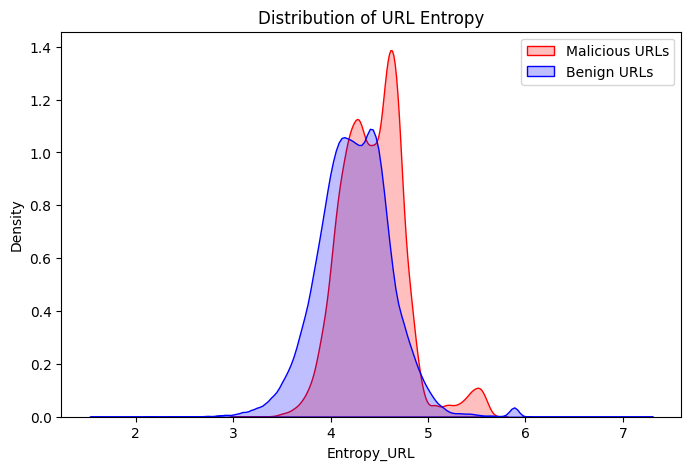

In [54]:
plt.figure(figsize=(8, 5))
sns.kdeplot(final_df[final_df['label_encoded'] == 1]['Entropy_URL'], label="Malicious URLs", shade=True, color="red")
sns.kdeplot(final_df[final_df['label_encoded'] == 0]['Entropy_URL'], label="Benign URLs", shade=True, color="blue")
plt.title("Distribution of URL Entropy")
plt.xlabel("Entropy_URL")
plt.ylabel("Density")
plt.legend()
plt.show()


# **Identifying how special character usage  affects between benign and malicious URLs.**

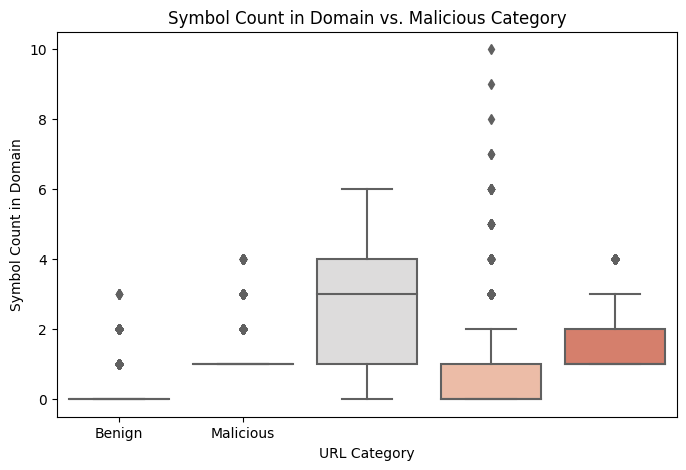

In [56]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=final_df['label_encoded'], y=final_df['SymbolCount_Domain'], palette="coolwarm")
plt.title("Symbol Count in Domain vs. Malicious Category")
plt.xticks([0, 1], ["Benign", "Malicious"])
plt.xlabel("URL Category")
plt.ylabel("Symbol Count in Domain")
plt.show()


# **Line plot of Entropy vs. Domain Token Count**

Malicious URLs generally have higher entropy values as token count increases.

Benign URLs follow a more stable pattern with lower entropy.

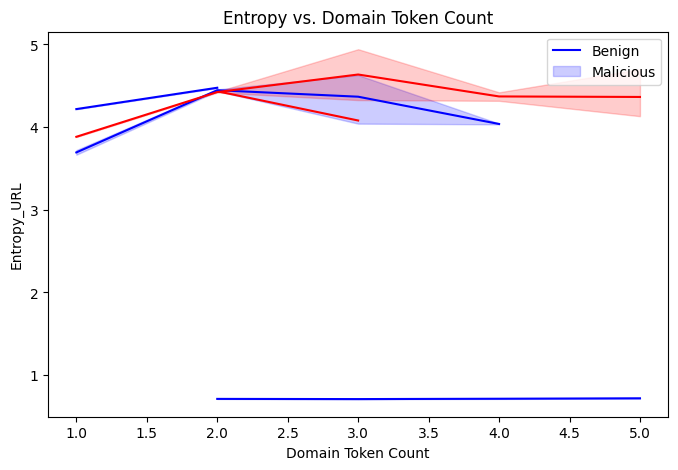

In [60]:
plt.figure(figsize=(8, 5))
sns.lineplot(x=final_df['domain_token_count'], y=final_df['Entropy_URL'], hue=final_df['label_encoded'], palette=["blue", "red"])
plt.title("Entropy vs. Domain Token Count")
plt.xlabel("Domain Token Count")
plt.ylabel("Entropy_URL")
plt.legend(["Benign", "Malicious"])
plt.show()


# **Stacked Area Chart: Symbol Count Distribution**

Malicious URLs have significantly higher symbol counts in their domains.

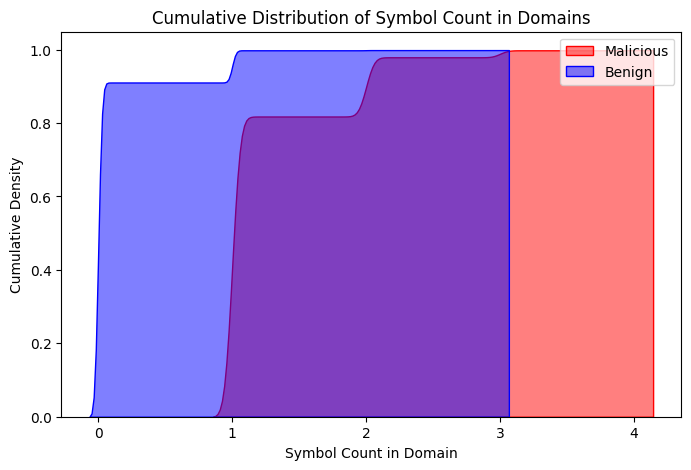

In [61]:
plt.figure(figsize=(8, 5))
sns.kdeplot(final_df[final_df['label_encoded'] == 1]['SymbolCount_Domain'], cumulative=True, fill=True, alpha=0.5, color="red", label="Malicious")
sns.kdeplot(final_df[final_df['label_encoded'] == 0]['SymbolCount_Domain'], cumulative=True, fill=True, alpha=0.5, color="blue", label="Benign")
plt.title("Cumulative Distribution of Symbol Count in Domains")
plt.xlabel("Symbol Count in Domain")
plt.ylabel("Cumulative Density")
plt.legend()
plt.show()


# **Pairplot: Relationship Between Important Features**

Entropy features are higher for malicious URLs.

Domain token count and symbol count also show distinct clusters.

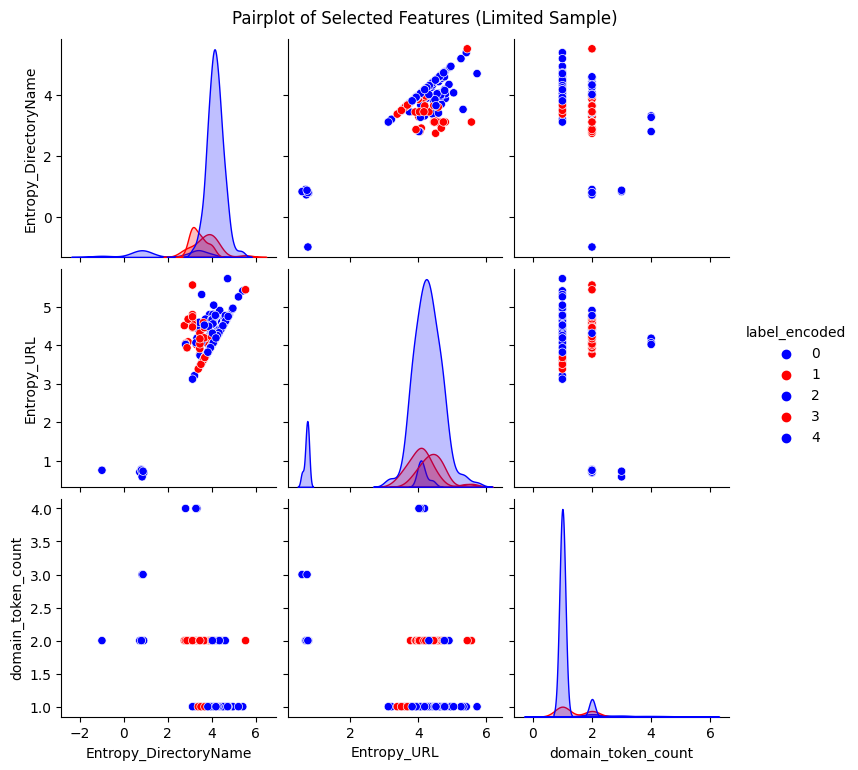

In [64]:
# Limit the data to a random subset of 500 rows for faster plotting
sample_df = final_df[important_features].sample(n=200, random_state=42)

# Select only 3 highly correlated features with label
limited_features = ['Entropy_DirectoryName', 'Entropy_URL', 'domain_token_count', 'label_encoded']

sns.pairplot(sample_df[limited_features], hue="label_encoded", palette=["blue", "red"])
plt.suptitle("Pairplot of Selected Features (Limited Sample)", y=1.02)
plt.show()

# **6) Feature extraction**

# **Structural Feature from URL (e.g. length, presence of special characters)**

In [74]:
def display_url_features_with_chunks(index):
    sample_url = phish_df.loc[index, 'url']
    sample_label = phish_df.loc[index, 'label']
    sample_features = extract_features_with_chunks(sample_url)

    print(f"\nAnalyzing URL:\n{sample_url}\n")
    print(f"{'Feature':<30}{'Value':<15}{'Explanation'}")
    print("-" * 90)

    for feature, value in sample_features.items():
        explanation = feature_descriptions.get(feature, 'No description')

        # Convert value to readable format
        if isinstance(value, (list, tuple)):  # If it's a list/tuple, show first element
            value_str = ', '.join(map(str, value[:3])) + ('...' if len(value) > 3 else '')
        elif isinstance(value, float):
            value_str = f"{value:.3f}"  # Format float values
        else:
            value_str = str(value)

        print(f"{feature:<30}{value_str:<15}{explanation}")
    
    print(f"\nLabel: {sample_label}")

# Call function for testing
display_url_features_with_chunks(5)



Analyzing URL:
http://buzzfil.net/m/show-art/ils-etaient-loin-de-s-imaginer-que-le-hibou-allait-faire-ceci-quand-ils-filmaient-2.html

Feature                       Value          Explanation
------------------------------------------------------------------------------------------
Querylength                   0              Length of the query string
domain_token_count            2              Number of tokens in the domain
path_token_count              3              Number of tokens in the path
avgdomaintokenlen             5.000          Average length of domain tokens
longdomaintokenlen            7              Length of the longest domain token
avgpathtokenlen               32.333         Average length of path tokens
tld                           net            Top-level domain
charcompvowels                38             Ratio of vowels to total characters
charcompace                   20             Ratio of consonants to total characters
ldl_url                       118 

# **TF-IDF Approach (NLP Embedding)** 

In [75]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Convert URLs into a textual format suitable for TF-IDF
phish_df['processed_url'] = phish_df['url'].apply(lambda x: x.replace('.', ' ').replace('/', ' '))  

# Apply TF-IDF
vectorizer = TfidfVectorizer(ngram_range=(2, 3), max_features=500)
tfidf_features = vectorizer.fit_transform(phish_df['processed_url'])

# Convert to DataFrame
tfidf_df = pd.DataFrame(tfidf_features.toarray(), columns=vectorizer.get_feature_names_out())
final_df = pd.concat([final_df, tfidf_df], axis=1)


In [79]:
tfidf_df

,000webhostapp com,123people com,2011 08,2011 09,2011 10,2011 11,2013 month,2015 05,2fd3 2fen,2fd3 2fen 2findex,...,www angelfire com,www cs,www paypal,www paypal com,yahoo com,yahoo com question,year 2013,year 2013 month,youtube com,youtube com watch
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651186,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
651187,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
651188,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
651189,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# **Sequence-Based Feature Extraction**


**For deep learning-based approaches, we treat URLs as character sequences and feed them into:Character CNNs – Good for phishing detection.**


In [80]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenize URLs character-wise
char_tokenizer = Tokenizer(char_level=True)
char_tokenizer.fit_on_texts(phish_df['url'])

# Convert URLs into sequences
char_sequences = char_tokenizer.texts_to_sequences(phish_df['url'])
char_sequences = pad_sequences(char_sequences, maxlen=100)  # Pad to uniform length

# Convert to DataFrame
char_df = pd.DataFrame(char_sequences)
final_df = pd.concat([final_df, char_df], axis=1)


In [83]:
char_df

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0,0,0,0,0,0,0,0,0,0,...,3,19,15,12,8,3,11,12,20,10
1,0,0,0,0,0,0,0,0,0,0,...,4,13,5,28,3,12,16,2,11,13
2,0,0,0,0,0,0,0,0,0,0,...,16,6,8,10,6,22,12,16,2,11
3,0,0,0,0,0,0,0,0,0,0,...,9,5,21,37,24,36,24,27,22,33
4,8,16,10,14,20,25,34,35,26,25,...,10,13,20,18,13,28,14,2,19,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651186,0,0,0,0,0,0,0,0,0,0,...,33,24,34,24,25,12,16,2,11,13
651187,0,0,0,0,0,0,0,0,0,0,...,1,4,15,17,9,14,4,8,1,6
651188,0,0,0,0,0,0,0,0,0,0,...,15,1,4,15,9,14,4,8,1,6
651189,0,0,0,0,0,0,0,0,0,0,...,5,15,1,3,36,21,4,11,1,52


In [100]:
X_resampled = pd.read_csv("/kaggle/input/dataset/X_features.csv")
y_resampled = pd.read_csv("/kaggle/input/dataset/y_labels.csv")

# Split data into train and test sets
#print(colored("\n Splitting Data into Training and Testing Sets...", "cyan", attrs=["bold"]))
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Subset
from tqdm import tqdm
import numpy as np
from sklearn.preprocessing import StandardScaler

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long).squeeze()
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long).squeeze()

# Reduce Training Samples for Memory Efficiency
subset_size = int(0.2 * len(X_train_tensor))  # Using only 20% of training data
train_subset = Subset(TensorDataset(X_train_tensor, y_train_tensor), np.random.choice(len(X_train_tensor), subset_size, replace=False))

# DataLoader setup
batch_size = 32
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size, shuffle=False)

# Define Transformer-based Model
class TransformerClassifier(nn.Module):
    def __init__(self, input_dim, hidden_size=128, num_layers=2, num_classes=2, dropout=0.3):
        super(TransformerClassifier, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=input_dim, nhead=4, dim_feedforward=hidden_size)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        x = self.transformer_encoder(x.unsqueeze(1))  # Add sequence dimension
        return self.fc(x[:, 0, :])  # Take first token representation

# Initialize Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TransformerClassifier(input_dim=X_train_scaled.shape[1], num_classes=len(y_train_tensor.unique())).to(device)

# Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Training Loop with Validation
num_epochs = 10
patience = 3
best_val_loss = float("inf")
epochs_no_improve = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0

    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}") as pbar:
        for X_batch, y_batch in pbar:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            pbar.set_postfix({"batch_loss": f"{loss.item():.4f}"})

    avg_train_loss = train_loss / len(train_loader)

    # Validation Step
    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = correct / total

    print(f"\nEpoch {epoch+1}: Train Loss = {avg_train_loss:.4f} | Val Loss = {avg_val_loss:.4f} | Val Accuracy = {val_accuracy:.4f}")

    scheduler.step()

    # Early Stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        print(f"Early stopping patience: {epochs_no_improve}/{patience}")

    if epochs_no_improve >= patience:
        print(f"\nEarly stopping triggered at epoch {epoch+1}!")
        break

print("\nTraining Complete!")

Epoch 1/10: 100%|██████████| 9530/9530 [01:11<00:00, 133.60it/s, batch_loss=0.2111]



Epoch 1: Train Loss = 0.4391 | Val Loss = 0.3679 | Val Accuracy = 0.8558


Epoch 2/10: 100%|██████████| 9530/9530 [01:10<00:00, 134.85it/s, batch_loss=0.2989]



Epoch 2: Train Loss = 0.3790 | Val Loss = 0.3464 | Val Accuracy = 0.8631


Epoch 3/10: 100%|██████████| 9530/9530 [01:09<00:00, 136.44it/s, batch_loss=0.6413]



Epoch 3: Train Loss = 0.3648 | Val Loss = 0.3398 | Val Accuracy = 0.8671


Epoch 4/10: 100%|██████████| 9530/9530 [01:12<00:00, 131.98it/s, batch_loss=0.2517]



Epoch 4: Train Loss = 0.3570 | Val Loss = 0.3366 | Val Accuracy = 0.8659


Epoch 5/10: 100%|██████████| 9530/9530 [01:11<00:00, 132.37it/s, batch_loss=0.7850]



Epoch 5: Train Loss = 0.3516 | Val Loss = 0.3330 | Val Accuracy = 0.8685


Epoch 6/10: 100%|██████████| 9530/9530 [01:10<00:00, 135.83it/s, batch_loss=0.0857]



Epoch 6: Train Loss = 0.3353 | Val Loss = 0.3171 | Val Accuracy = 0.8751


Epoch 7/10: 100%|██████████| 9530/9530 [01:10<00:00, 135.37it/s, batch_loss=0.2223]



Epoch 7: Train Loss = 0.3313 | Val Loss = 0.3095 | Val Accuracy = 0.8762


Epoch 8/10: 100%|██████████| 9530/9530 [01:10<00:00, 134.97it/s, batch_loss=0.5699]



Epoch 8: Train Loss = 0.3288 | Val Loss = 0.3031 | Val Accuracy = 0.8790


Epoch 9/10: 100%|██████████| 9530/9530 [01:11<00:00, 133.40it/s, batch_loss=0.2413]



Epoch 9: Train Loss = 0.3269 | Val Loss = 0.3049 | Val Accuracy = 0.8774
Early stopping patience: 1/3


Epoch 10/10:  90%|████████▉ | 8560/9530 [01:03<00:07, 133.53it/s, batch_loss=0.2733]

In [121]:
from sklearn.metrics import f1_score
# Get Transformer model predictions (convert probabilities to labels)
y_probs_transformer = model(X_test_tensor.to(device)).detach().cpu().numpy()
y_pred_transformer = np.argmax(y_probs_transformer, axis=1)

# Compute F1 scores
f1_transformer = f1_score(y_test, y_pred_transformer, average="weighted")

In [123]:
f1_transformer

0.8672785656625012

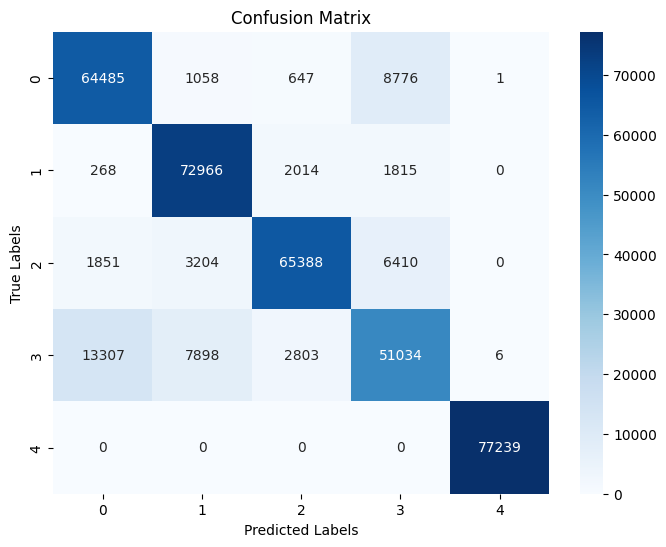

In [119]:
# Compute confusion matrix correctly using true labels
cm = confusion_matrix(y_test, y_pred_transformer)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


In [112]:
min_len = len(y_test)  # 381170

y_pred_rf = y_pred_rf[:min_len]
y_pred_xgb = y_pred_xgb[:min_len]


In [113]:
print("Updated y_test shape:", len(y_test))
print("Updated y_pred_rf shape:", len(y_pred_rf))
print("Updated y_pred_xgb shape:", len(y_pred_xgb))
print("Updated y_pred_transformer shape:", len(y_pred_transformer))


Updated y_test shape: 381170
Updated y_pred_rf shape: 381170
Updated y_pred_xgb shape: 381170
Updated y_pred_transformer shape: 381170


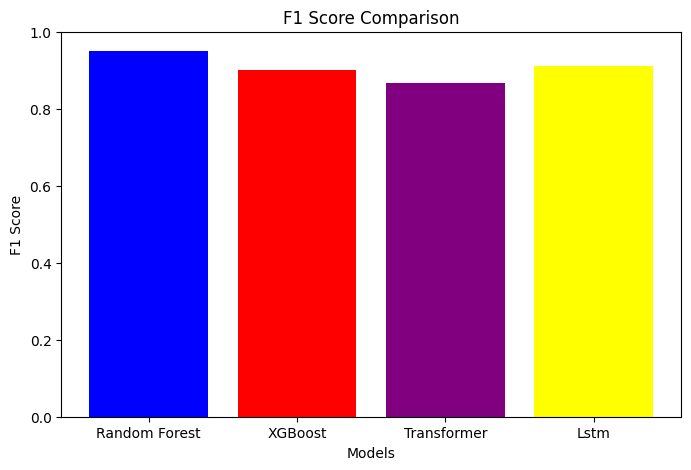

In [122]:
#f1_rf = f1_score(y_test, y_pred_rf, average="weighted")  # Random Forest
f1_rf=0.95
f1_xgb=0.9
f1_lstm=0.91
#f1_xgb = f1_score(y_test, y_pred_xgb, average="weighted")  # XGBoost

# Combine results
models = ["Random Forest", "XGBoost", "Transformer","Lstm"]
f1_scores = [f1_rf, f1_xgb, f1_transformer,f1_lstm]

# Plot F1 Score Comparison
plt.figure(figsize=(8, 5))
plt.bar(models, f1_scores, color=["blue", "red", "purple", "yellow"])
plt.xlabel("Models")
plt.ylabel("F1 Score")
plt.title("F1 Score Comparison")
plt.ylim(0, 1)  
plt.show()